In [2]:
import sys
print(sys.version)
%matplotlib inline
%run -i ~/Python/pjr3

3.10.1 | packaged by conda-forge | (main, Dec 22 2021, 01:39:05) [GCC 9.4.0]
pjr3.py complete


In [10]:
indir = os.path.expanduser('~/NetCDF_Files/*F2010*.nc')
#indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h2.2015-01-01-00000.nc')
indir = os.path.expanduser('~/NetCDF_Files/*F2010*01.nc')
#indir = os.path.expanduser('~/NetCDF_Files/vd05_ANN_climo.nc')

print(indir)
#print('exists',os.path.exists(indir))
DS = xr.open_mfdataset(indir).chunk({'time': 20})
print('DS',DS)
weights = DS.area
weights.name = 'weights'
Var = DS.FSNT - DS.FLNT  # net radiative flux at Top of Model
print(Var.shape)
Varm2 = Var.weighted(weights).mean() # calculate global average
print('area weighted mean', Varm2.values)

/home/phil/NetCDF_Files/*F2010*01.nc
DS <xarray.Dataset>
Dimensions:          (ncol: 21600, lev: 72, ilev: 73, time: 1, nbnd: 2)
Coordinates:
  * lev              (lev) float64 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * ilev             (ilev) float64 0.1 0.1477 0.218 ... 990.5 997.0 1e+03
  * time             (time) object 0001-02-01 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/413)
    lat              (ncol) float64 dask.array<chunksize=(21600,), meta=np.ndarray>
    lon              (ncol) float64 dask.array<chunksize=(21600,), meta=np.ndarray>
    area             (ncol) float64 dask.array<chunksize=(21600,), meta=np.ndarray>
    hyam             (lev) float64 dask.array<chunksize=(72,), meta=np.ndarray>
    hybm             (lev) float64 dask.array<chunksize=(72,), meta=np.ndarray>
    P0               float64 ...
    ...               ...
    soa_c1DDF        (time, ncol) float32 dask.array<chunksize=(1, 21600), meta=np.ndarray>
    soa_c1SFWET    

In [5]:
# interpolate xarray datavariable on eta hybrid surfaces to 20 pressure levels
Tin = DS.T
Tin = Tin.squeeze()
#print("Tin",Tin)

# calculate the pressure levels for the model from PS and the hybrid coordinates
Pin = (DS.hyam*DS.P0 + DS.hybm*DS.PS)/100.
Pin.attrs["units"] = 'hPa'
Pin.attrs["long_name"] = 'Pressure'
Pin = Pin.squeeze()

# specify the pressures to interpolate to
nzout = 20
pout = np.linspace(1.,1000.,nzout)


Tout = hy2plev(Tin, Pin, pout)
print('Tout',Tout)

Tout <xarray.DataArray (plev: 20, ncol: 21600)>
array([[271.77803314, 271.88166787, 271.58988583, ..., 247.45571226,
        247.4806769 , 248.20443033],
       [213.18663947, 213.6021184 , 212.35790378, ..., 215.45417854,
        215.52250377, 215.15539015],
       [205.35539304, 206.11643913, 203.86083285, ..., 211.83477059,
        212.17812236, 210.99015355],
       ...,
       [287.21514669, 286.62321389, 288.49389508, ..., 267.40549609,
        268.11114787, 268.51219565],
       [289.76341564, 289.04907859, 291.03213896, ..., 271.57738751,
        272.35397103, 272.69652137],
       [292.65288394, 292.11240069, 293.54021051, ..., 275.8186439 ,
                 nan, 276.94223309]])
Coordinates:
    time     object 0001-02-01 00:00:00
  * plev     (plev) float64 1.0 53.58 106.2 158.7 ... 842.3 894.8 947.4 1e+03
Dimensions without coordinates: ncol
Attributes:
    mdims:          1
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature
    cell_me

In [6]:
def gcd(lon1, lat1, lon2, lat2):
    """calculate great circle distance in km
       given input longitude and latitudes in degrees
    """
    d2r = 57.296
    lonr1 = lon1/d2r
    latr1 = lat1/d2r
    lonr2 = lon2/d2r
    latr2 = lat2/d2r

    d = 6371.*(np.arccos(np.sin(latr1) * np.sin(latr2) + np.cos(latr1) * np.cos(latr2) * np.cos(lonr1 - lonr2)))
    return d

lat = DS['lat'].values#[0,:]
lon = DS['lon'].values#[0,:]
print('xxx',lat[10],lon[10])
tlon = 321.6
tlat = -35.8
dd = gcd(lon,lat, tlon, tlat)

ind = np.where(dd == np.min(dd))
ind = int(ind[0])
print('ind',ind,lat[ind],lon[ind])

xxx -35.98099838266331 321.74210020666715
ind 10 -35.98099838266331 321.74210020666715


dist 0.7500003953503928 -88.93939984132163 117.94418571451939
xxx 1.061000000000007
ind 16260 -88.93939984132163 44.99999999999992


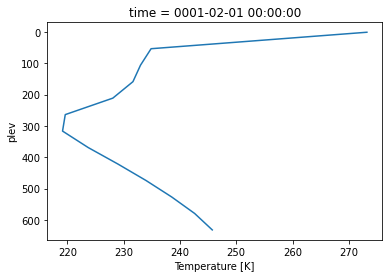

In [7]:
# plot a column specified by xlook and ylook for fields specified on a cubed sphere grid
xlook = 0.
ylook = -90.
lat = DS['lat'].values#[0,:]
lon = DS['lon'].values#[0,:]
#dist = np.abs(ylook-lat) + np.abs(xlook-lon)
dist = gcd(lon,lat, xlook, ylook)

print('dist',lon.min(),lat.min(),dist.min())
print('xxx',-88.939-ylook)
# find the index closest to xlook ylook
ind = np.where(dist == np.min(dist))
ind = int(ind[0])
print('ind',ind,lat[ind],lon[ind])
Toutm = Tout[:,ind]
pl = Toutm.plot(y="plev",yincrease=False)

dmin,dmax 246.86406668657014 298.17111960514734


RuntimeError: Error in qhull Delaunay triangulation calculation: input inconsistency (exitcode=1); use python verbose option (-v) to see original qhull error.

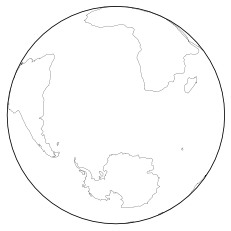

In [8]:
# a simple method to plot a horizontal field using a map projection.
# this method is fine for plots where you dont care too much about the exact shape of the cells
# the plot uses triangulation from cell center to cell center. Other methods are better for knowing exactly the shape of each cell

#indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h0.2015-01.nc')
DS = xr.open_mfdataset(indir).chunk({'time': 20})
Tout = DS.PS.isel(time=0)
#indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h2.2015-01-01-00000.nc')
#DS = xr.open_mfdataset(indir).chunk({'time': 20})
#Tout = DS.T850.isel(time=0)

#gridfile = '/lustre/d3x345/maps/ne30pg2_scrip_c20191218.nc'

Tin = DS.T
Tin = Tin.squeeze()

Pin = (DS.hyam*DS.P0 + DS.hybm*DS.PS)/100.
Pin.attrs["units"] = 'hPa'
Pin.attrs["long_name"] = 'Pressure'
Pin = Pin.squeeze()

pout = 850.

Tout2 = hy2plev(Tin, Pin, pout).squeeze()

# Read data
data = Tout2

lon = DS['lon']
lat = DS['lat']

dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
plotproj=ccrs.Orthographic(central_latitude=-50)   # any projections should work 
ax = plt.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)

tcoords = plotproj.transform_points(dataproj,np.array(lon[:]),np.array(lat[:]))
data2d = data
xi=tcoords[:,0]!=np.inf
tc=tcoords[xi,:]
datai=data2d[:][xi]  # convert to numpy array, then subset
dmin = datai.min().values
dmax = datai.max().values
print('dmin,dmax',dmin,dmax)
pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='gouraud',vmin=dmin,vmax=dmax) # looks good
#pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='flat') # looks bad
# Add colorbar to plot
cb = plt.colorbar(
    pl, orientation='horizontal',
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

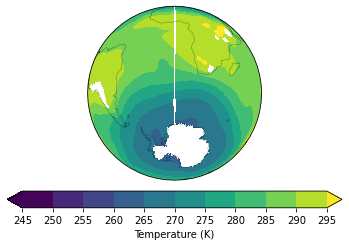

In [9]:
# create a regular lat/lon grid
# OK for quick and dirty plotting, but leaves NaNs near domain edges
from scipy.interpolate import griddata
import numpy

xi = numpy.linspace(0, 360, 361)  # to regrid to 1/2 degree
yi = numpy.linspace(-90, 90, 181)  # to regrid to 1/2 degree

data_regridded = griddata((lon, lat), data2d, (xi[None,:], yi[:,None]), method='linear')
df = data_regridded.flatten()
dsub = df[np.isfinite(df)] # ignore NaN
zmax = dsub.max()
zmin = dsub.min()

dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
plotproj=ccrs.Orthographic(central_latitude=-50)   # any projections should work 
ax = plt.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)
clevs = findNiceContours(np.array([dmin,dmax]),nlevs=10)
pl = ax.contourf(xi, yi, data_regridded, clevs, vmin=dmin, vmax=dmax,  extend='both', transform=ccrs.PlateCarree())
# Add colorbar to plot
cb = plt.colorbar(
    pl, orientation='horizontal',ticks=clevs,
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)
plt.show